# Final Project

Matheus Azevedo Silva Pessôa

As a final project, I decided to work on detecting sound sources first by using the matched filter method we learned in our classes. The data files I used were from an experiment performed where a sound source was randomnly placed near 8 microphones. Those microphones recorded the sound emitted by the source, and the idea is to verify if the sound can be found in all microphones. Ideally, it would be interesting to determine the exact position of the sound source with another method as well, but unfortunately that was not possible. Since it did not work with the matched filter, I studied how a Kalman filter works and inspired in an algorithm, I wrote a code that can use prior measurements to predict the position of a particle. This can have many different applications!

# Matched filter part

We begin by importing the libraries we will use. 

In [44]:
import wave
from matplotlib import pyplot as plt
from scipy.io import wavfile
import numpy as np
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

In [12]:
a = wave.open('1.wav','rb')

Now we take a look at one part of the data we have, and the FFT, as well as the PSD.

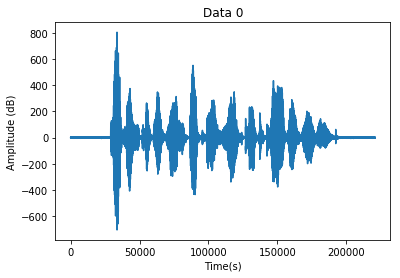

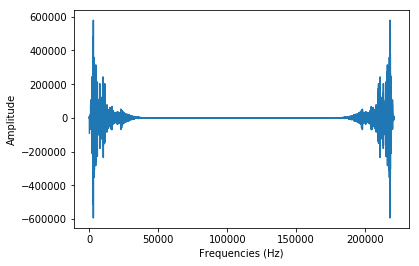

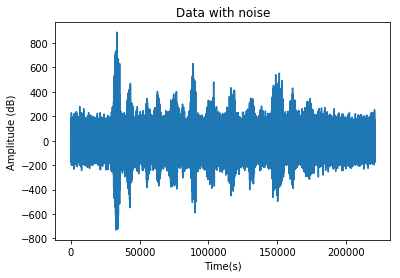

In [22]:
fs, data = wavfile.read('1 (1).wav')
data0 = data[:,0]
data1 = data[:,1]
data2 = data[:,2]
psd0 = np.abs(np.fft.fft(data0)**2)
plt.plot(data0)
plt.title('Data 0')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude (dB)')
plt.show()

plt.plot(np.fft.fft(data0))
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Amplitude')
plt.show()

N = np.random.normal(np.mean(data0),np.std(data0),len(data0)) # noise

plt.plot(data0 + N)
plt.title('Data with noise')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude (dB)')
plt.show()

In order to use the matched filter method, we first need to window our data. In this case, I will use a Blackman Harris window.

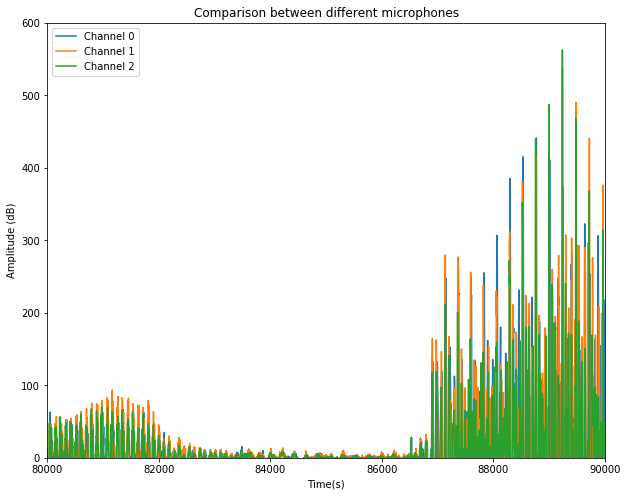

In [32]:
def window(data, window_fn="blackmanharris"):
    data = data * scipy.signal.get_window(window_fn,len(data))
    windowed_data = data
    return windowed_data
plt.figure(figsize=(10,8))
w0 = window(data0)
w1 = window(data1)
w2 = window(data2)
plt.plot(w0, label = 'Channel 0')
plt.plot(w1,label = 'Channel 1')
plt.plot(w2,label = 'Channel 2')
plt.xlim(80000,90000)
plt.ylim(0,600)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude (dB)')
plt.title('Comparison between different microphones')
plt.legend()
plt.show()

We noticed that the same sound reaches all channels but with different amplitudes, and at different instants of time as well. But how can we confirm the detection of the same sound file in all different channels? This is why we will use the matched filter method. 

First let us just take a look at the spectrogram of those different channels and see how frequencies are distributed.

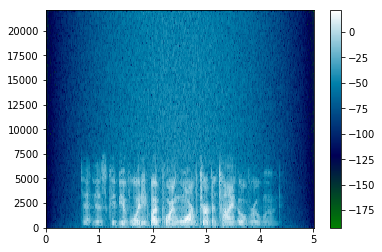

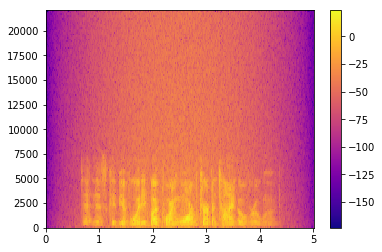

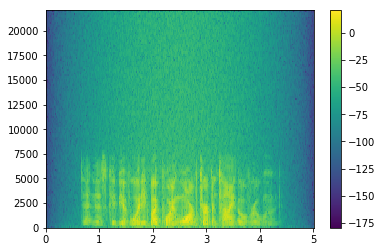

In [49]:
spec_cmap = 'ocean'
spec_map1 = 'plasma'

plt.specgram(w0, Fs = fs,cmap = spec_cmap)
plt.colorbar()
plt.show()
plt.specgram(w1, Fs = fs, cmap = spec_map1)
plt.colorbar()
plt.show()
plt.specgram(w2, Fs = fs)
plt.colorbar()
plt.show()

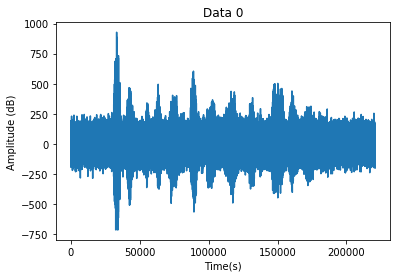

In [50]:
fs, data = wavfile.read('1 (1).wav')
number = []

data0 = data[:,0]
data1 = data[:,1]
data2 = data[:,2]
data3 = data[:,3]
data4 = data[:,4]
data5 = data[:,5]
data6 = data[:,6]
data7 = data[:,7]

N = np.random.normal(np.mean(data0),np.std(data0),len(data0)) # noise

plt.plot(data0 + N)
plt.title('Data 0')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude (dB)')
plt.show()

We will use the first channel as the template for detecting the same sound in all other microphones. For this, we take the complex conjugate of what we consider as the template (with the addition of gaussian noise as well), and apply the same treatment to the data we're trying to detect these sounds on.

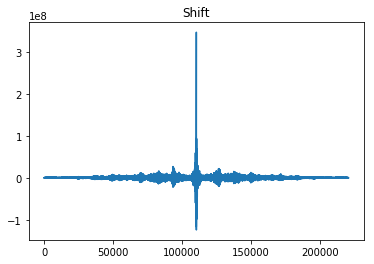

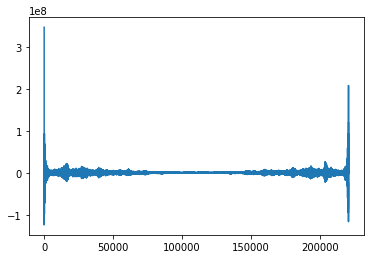

In [51]:
template = data[:,0] + N
wtemplate = window(template)
temp_fft = np.conj(np.fft.fft(wtemplate))

wdata1 = np.fft.fft(window(data1+N))
mf = wdata1 * temp_fft
mfr1 = np.fft.ifft(mf)
mf1 = np.fft.fftshift(mfr1)

plt.plot(mf1)
plt.title('Shift')
plt.show()

plt.plot(mfr1)
plt.show()

If the two signals match, we expect to see a sharp peak indicating the matching between two signals. In this case, we observe this is true for the datasets 0 and 1, and we will try to verify for other two channels as it follows.

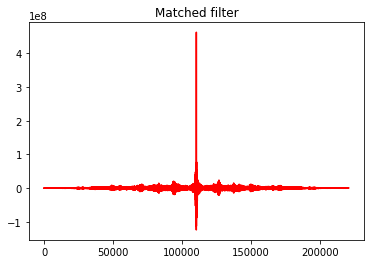

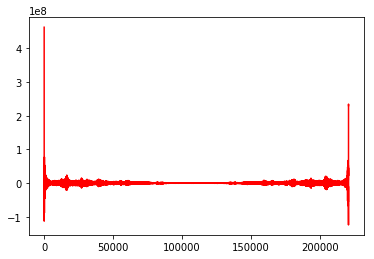

In [62]:
template = data[:,1] + N
wtemplate = window(template)
temp_fft = np.conj(np.fft.fft(wtemplate))

wdata1 = np.fft.fft(window(data2+N))
mf = wdata1 * temp_fft
mfr2 = np.fft.ifft(mf)
mf2 = np.fft.fftshift(mfr2)

plt.plot(mf2, color = 'red')
plt.title('Matched filter')
plt.show()

plt.plot(mfr2, color = 'red')
plt.show()

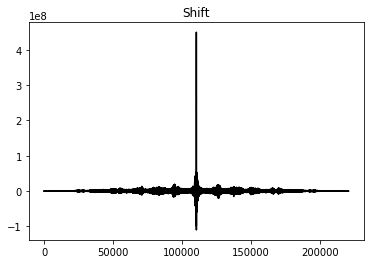

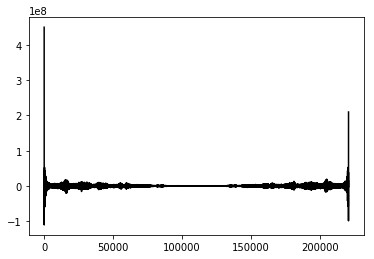

In [63]:
template = data[:,2] + N
wtemplate = window(template)
temp_fft = np.conj(np.fft.fft(wtemplate))

wdata1 = np.fft.fft(window(data3+N))
mf = wdata1 * temp_fft
mfr3 = np.fft.ifft(mf)
mf3 = np.fft.fftshift(mfr3)

plt.plot(mf3, color = 'black')
plt.title('Shift')
plt.show()

plt.plot(mfr3, color = 'black')
plt.show()

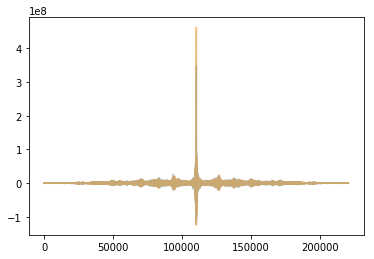

In [64]:
plt.plot(mf1,alpha = 0.3)
plt.plot(mf2,alpha = 0.5)
plt.plot(mf3, alpha = 0.1 )
plt.show()

# Kalman filter

Now since we were dealing with a problem that takes into account the position and movement of a sound source, this gave me an idea of trying to predict the subsequent positions of a moving car for example, knowing some information about its movement beforehand.

To attack this problem, I have studied a bit about something called a Kalman filter that takes into account the probabilities of each position. So consider we have the motion of a particle that follows,
$$
\begin{equation}
x(t) = x_0 + v_0 t
\end{equation}$$

Now imagine we have a sensor that can predict where this particle is at any given moment, and has an error of $1$m. The initial "tracking" is not so precise, so let's say we consider a variance of $2$ initially, and that for the initial position we have a variance of $20$m.  In order to evaluate the prediction power of this method, we also have the addition of noise to our measurements data, so we can see how the filter behaves.

In [153]:
t = np.array([i for i in range(0,30)]) # Time vector [s]
x0 = 0       # Initial position [m]
vx0 = 1   # Initial velocity [m/s]

velocity_vector=x0+vx0*t
N = 1+np.random.randn(t.size)
velocity_vector = velocity_vector +N 

print(velocity_vector)

[ 0.82169394  0.4767864   2.26794161  4.57515097  4.89678137  4.9209873
  7.65586153  7.77532091  8.4863208   8.74274627 11.50228578 12.83919354
 11.9443411  13.69162401 14.71589619 16.15003366 15.90574049 19.98292518
 19.2676099  20.87845989 20.66759053 24.0921686  23.44080739 22.18797545
 25.99620947 25.95004746 25.9329602  27.94073917 28.09589507 30.70275338]


We now build a prediction function, that takes the value of the prior position into account and also the variance. The multiplication of two Gaussians in bayesian terms can be expressed as,

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}).
\end{aligned}$$

This is how the Kalman filter works, multiplying the Gaussian distribution of particle positions.

final estimate:            30.057
actual final position:     30.703


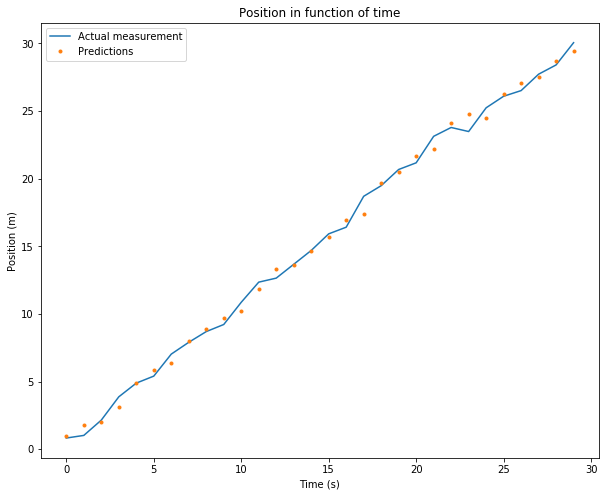

In [154]:
import filterpy.stats as stats
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

xs, predictions = [], []

process_var = 1. # variance in the particle's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # particle's initial position N(0, 20**2)
vx0 = 1
dt = 1. # time step in seconds
process_model = gaussian(vx0*dt, process_var) # displacement to add to a position


# perform Kalman filter on the velocity vector
for z in velocity_vector:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    predictions.append(prior.mean)
    xs.append(x.mean)
    
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(z))

plt.figure(figsize=(10,8))
plt.plot(xs, label = 'Actual measurement')
plt.plot(predictions,'.', label =  'Predictions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.title('Position in function of time')
plt.show()

The predictions are closely related to the actual measurements we created for the particle's velocity. So we can say the implementation of the Kalman Filter worked well for our purposes!